#Setup

In [8]:
import os
import math
import timeit
import argparse
import numpy as np
import pickle
import random
import gdown
from tqdm import tqdm
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms

In [9]:
!gdown https://drive.google.com/file/d/1KJKOZ-DchNUjTGAzfNafNc5XYU2Bfagw/view?usp=share_link --fuzzy
!unzip scn_utils.zip
!rm scn_utils.zip

Downloading...
From: https://drive.google.com/uc?id=1KJKOZ-DchNUjTGAzfNafNc5XYU2Bfagw
To: /content/scn_utils.zip
100% 29.5k/29.5k [00:00<00:00, 43.7MB/s]
Archive:  scn_utils.zip
replace models/vgg.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: models/vgg.py           
  inflating: models/.DS_Store        
  inflating: __MACOSX/models/._.DS_Store  
  inflating: models/sconv.py         
  inflating: __MACOSX/models/._sconv.py  
  inflating: models/__init__.py      
  inflating: models/mlp.py           
  inflating: __MACOSX/models/._mlp.py  
  inflating: models/resnet.py        
  inflating: models/conv_shiftinv.py  
  inflating: models/__pycache__/resnet.cpython-37.pyc  
  inflating: models/__pycache__/sconv.cpython-37.pyc  
  inflating: models/__pycache__/mlp.cpython-37.pyc  
  inflating: models/__pycache__/vgg.cpython-37.pyc  
  inflating: models/__pycache__/conv_shiftinv.cpython-37.pyc  
  inflating: models/__pycache__/__init__.cpython-37.pyc  
  inflating: utils.py        

In [10]:
from models import *
import utils

In [11]:
dataset = 'FashionMNIST'
datadir = 'datasets'
arch = 'hhnmlpb'
batchsize = 64
epochs = 50
nlayers = 1
width = 32
lr = 0.001
dimensions = 3
hin = 2
nchannels = 1
nclasses = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load dataset

In [12]:
######## download datasets
kwargs = {'num_workers': 4, 'pin_memory': True}
train_dataset = utils.load_data("train", dataset, datadir)
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, **kwargs)
test_dataset = utils.load_data("test", dataset, datadir)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False, **kwargs)

Prepare SCN model

In [13]:
######## prepare model structure
save_dir = f'{arch}_{dataset}_{nlayers}_{width}_{dimensions}'
model = HHN_MLPB(hin=hin, dimensions=dimensions, n_layers=nlayers, n_units=width, n_channels=nchannels, n_classes=nclasses)

model.to(device)
print(model)
print(utils.count_model_parameters(model))

HHN_MLPB(
  (hyper_stack): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
    (3): Softmax(dim=0)
  )
  (weight_list_fc1): ParameterList(
      (0): Parameter containing: [torch.float32 of size 32x1024 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 32x1024 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 32x1024 (GPU 0)]
  )
  (bias_list_fc1): ParameterList(
      (0): Parameter containing: [torch.float32 of size 32 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 32 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 32 (GPU 0)]
  )
  (weights): ParameterList()
  (biases): ParameterList()
  (weight_list_fc2): ParameterList(
      (0): Parameter containing: [torch.float32 of size 10x32 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 10x32 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 10x32 (

In [14]:
def transform_angle(angle):
    cos = math.cos(angle / 180 * math.pi)
    sin = math.sin(angle / 180 * math.pi)
    return Tensor([cos, sin])

Train model

In [15]:
######## train model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=25)

cos = nn.CosineSimilarity(dim=0, eps=1e-6)

def train(dataloader, model, loss_fn, optimizer):
    for batch, (X, y) in enumerate(tqdm(dataloader, desc='Training')):
        angle = random.uniform(0, 360)
        X, y = X.to(device), y.to(device)
        X = TF.rotate(X, angle)
        Hyper_X = transform_angle(angle).to(device)

        pred = model(X, Hyper_X)
        loss = loss_fn(pred, y)

        beta1 = model.hyper_stack(Hyper_X)
        angle2 = random.uniform(0, 360)
        beta2 = model.hyper_stack(transform_angle(angle2).to(device))
        loss += pow(cos(beta1, beta2),2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()

def validate(dataloader, model, loss_fn):
    angle = random.uniform(0, 360)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = TF.rotate(X, angle)
            Hyper_X = transform_angle(angle).to(device)

            pred = model(X, Hyper_X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test with angle={angle}: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss

for t in range(epochs):
    print(f"=================\n Epoch: {t + 1} \n=================")
    train(train_loader, model, loss_fn, optimizer)
    test_acc, test_loss = validate(test_loader, model, loss_fn)
print("Done!")

 Epoch: 1 


Training: 100%|██████████| 938/938 [00:12<00:00, 74.92it/s]


Test with angle=76.66681874210849: Accuracy: 72.5%, Avg loss: 0.756148
 Epoch: 2 


Training: 100%|██████████| 938/938 [00:09<00:00, 98.95it/s]


Test with angle=55.23977633278906: Accuracy: 72.5%, Avg loss: 0.774977
 Epoch: 3 


Training: 100%|██████████| 938/938 [00:09<00:00, 98.56it/s] 


Test with angle=84.8178453177511: Accuracy: 72.5%, Avg loss: 0.724494
 Epoch: 4 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.48it/s] 


Test with angle=254.6329481793028: Accuracy: 75.4%, Avg loss: 0.658471
 Epoch: 5 


Training: 100%|██████████| 938/938 [00:09<00:00, 96.98it/s]


Test with angle=299.8010429039711: Accuracy: 74.7%, Avg loss: 0.675756
 Epoch: 6 


Training: 100%|██████████| 938/938 [00:09<00:00, 99.57it/s]


Test with angle=123.50335988050358: Accuracy: 76.5%, Avg loss: 0.625660
 Epoch: 7 


Training: 100%|██████████| 938/938 [00:09<00:00, 99.43it/s] 


Test with angle=328.86327338700806: Accuracy: 78.5%, Avg loss: 0.584281
 Epoch: 8 


Training: 100%|██████████| 938/938 [00:09<00:00, 98.63it/s] 


Test with angle=103.71826546617362: Accuracy: 75.7%, Avg loss: 0.652080
 Epoch: 9 


Training: 100%|██████████| 938/938 [00:09<00:00, 98.56it/s] 


Test with angle=155.78458083839948: Accuracy: 76.3%, Avg loss: 0.625639
 Epoch: 10 


Training: 100%|██████████| 938/938 [00:09<00:00, 98.28it/s] 


Test with angle=100.62839590568036: Accuracy: 79.4%, Avg loss: 0.571694
 Epoch: 11 


Training: 100%|██████████| 938/938 [00:09<00:00, 96.58it/s] 


Test with angle=95.32522647228048: Accuracy: 77.8%, Avg loss: 0.615327
 Epoch: 12 


Training: 100%|██████████| 938/938 [00:09<00:00, 99.44it/s] 


Test with angle=19.15096149495281: Accuracy: 77.9%, Avg loss: 0.598185
 Epoch: 13 


Training: 100%|██████████| 938/938 [00:10<00:00, 93.45it/s]


Test with angle=257.54654183848845: Accuracy: 78.5%, Avg loss: 0.587189
 Epoch: 14 


Training: 100%|██████████| 938/938 [00:09<00:00, 96.16it/s] 


Test with angle=117.66372160926392: Accuracy: 78.6%, Avg loss: 0.589665
 Epoch: 15 


Training: 100%|██████████| 938/938 [00:09<00:00, 98.85it/s]


Test with angle=251.76741392225793: Accuracy: 78.2%, Avg loss: 0.592662
 Epoch: 16 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.07it/s] 


Test with angle=279.33212668244204: Accuracy: 78.6%, Avg loss: 0.587735
 Epoch: 17 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.28it/s]


Test with angle=346.0515773394713: Accuracy: 77.5%, Avg loss: 0.602268
 Epoch: 18 


Training: 100%|██████████| 938/938 [00:09<00:00, 99.64it/s] 


Test with angle=131.2277562880346: Accuracy: 79.0%, Avg loss: 0.578538
 Epoch: 19 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.39it/s]


Test with angle=37.82618707462807: Accuracy: 79.4%, Avg loss: 0.565771
 Epoch: 20 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.72it/s] 


Test with angle=81.85455793904109: Accuracy: 79.4%, Avg loss: 0.565787
 Epoch: 21 


Training: 100%|██████████| 938/938 [00:09<00:00, 98.32it/s] 


Test with angle=198.99138278083058: Accuracy: 80.7%, Avg loss: 0.534433
 Epoch: 22 


Training: 100%|██████████| 938/938 [00:09<00:00, 96.09it/s] 


Test with angle=4.910590141668285: Accuracy: 79.6%, Avg loss: 0.555383
 Epoch: 23 


Training: 100%|██████████| 938/938 [00:09<00:00, 96.74it/s]


Test with angle=157.70785324970007: Accuracy: 79.1%, Avg loss: 0.574320
 Epoch: 24 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.24it/s] 


Test with angle=168.59014566493119: Accuracy: 80.1%, Avg loss: 0.546390
 Epoch: 25 


Training: 100%|██████████| 938/938 [00:09<00:00, 96.58it/s]


Test with angle=188.55015545126508: Accuracy: 79.9%, Avg loss: 0.559316
 Epoch: 26 


Training: 100%|██████████| 938/938 [00:09<00:00, 96.90it/s] 


Test with angle=152.95008328951275: Accuracy: 79.9%, Avg loss: 0.554757
 Epoch: 27 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.62it/s]


Test with angle=283.82564935615704: Accuracy: 79.2%, Avg loss: 0.564108
 Epoch: 28 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.76it/s]


Test with angle=40.87027109197591: Accuracy: 79.8%, Avg loss: 0.562237
 Epoch: 29 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.67it/s]


Test with angle=173.60792081466323: Accuracy: 78.2%, Avg loss: 0.589416
 Epoch: 30 


Training: 100%|██████████| 938/938 [00:09<00:00, 95.14it/s]


Test with angle=315.2996793663644: Accuracy: 81.1%, Avg loss: 0.520303
 Epoch: 31 


Training: 100%|██████████| 938/938 [00:09<00:00, 98.89it/s] 


Test with angle=71.76176122086405: Accuracy: 80.6%, Avg loss: 0.536812
 Epoch: 32 


Training: 100%|██████████| 938/938 [00:09<00:00, 98.16it/s] 


Test with angle=174.68053724814345: Accuracy: 80.0%, Avg loss: 0.544666
 Epoch: 33 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.58it/s]


Test with angle=347.4521158542299: Accuracy: 81.1%, Avg loss: 0.526416
 Epoch: 34 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.35it/s] 


Test with angle=309.68073771876175: Accuracy: 80.9%, Avg loss: 0.524160
 Epoch: 35 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.31it/s] 


Test with angle=207.56518723748394: Accuracy: 82.0%, Avg loss: 0.505828
 Epoch: 36 


Training: 100%|██████████| 938/938 [00:09<00:00, 96.89it/s] 


Test with angle=95.79039612013861: Accuracy: 81.2%, Avg loss: 0.521968
 Epoch: 37 


Training: 100%|██████████| 938/938 [00:09<00:00, 98.40it/s] 


Test with angle=28.002615267830958: Accuracy: 80.9%, Avg loss: 0.524910
 Epoch: 38 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.54it/s] 


Test with angle=106.65453642874546: Accuracy: 81.6%, Avg loss: 0.514448
 Epoch: 39 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.14it/s] 


Test with angle=291.39706765208405: Accuracy: 80.4%, Avg loss: 0.534683
 Epoch: 40 


Training: 100%|██████████| 938/938 [00:09<00:00, 98.36it/s]


Test with angle=159.56772201023634: Accuracy: 81.1%, Avg loss: 0.531720
 Epoch: 41 


Training: 100%|██████████| 938/938 [00:09<00:00, 96.70it/s]


Test with angle=42.58357076574414: Accuracy: 81.3%, Avg loss: 0.516692
 Epoch: 42 


Training: 100%|██████████| 938/938 [00:09<00:00, 94.40it/s]


Test with angle=191.83272233234425: Accuracy: 81.8%, Avg loss: 0.514522
 Epoch: 43 


Training: 100%|██████████| 938/938 [00:09<00:00, 96.66it/s]


Test with angle=53.611750532703205: Accuracy: 81.5%, Avg loss: 0.520618
 Epoch: 44 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.76it/s]


Test with angle=54.99978074519213: Accuracy: 81.2%, Avg loss: 0.522871
 Epoch: 45 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.98it/s] 


Test with angle=340.1670942522038: Accuracy: 81.8%, Avg loss: 0.505027
 Epoch: 46 


Training: 100%|██████████| 938/938 [00:10<00:00, 93.14it/s]


Test with angle=166.77619257051006: Accuracy: 81.4%, Avg loss: 0.512004
 Epoch: 47 


Training: 100%|██████████| 938/938 [00:09<00:00, 96.07it/s]


Test with angle=166.8815231813201: Accuracy: 81.4%, Avg loss: 0.510934
 Epoch: 48 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.79it/s] 


Test with angle=281.900388281334: Accuracy: 80.7%, Avg loss: 0.527899
 Epoch: 49 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.62it/s]


Test with angle=157.80998402027868: Accuracy: 81.8%, Avg loss: 0.515109
 Epoch: 50 


Training: 100%|██████████| 938/938 [00:09<00:00, 97.47it/s] 


Test with angle=90.74752052744576: Accuracy: 82.2%, Avg loss: 0.494766
Done!


Test the model

In [16]:
######## test model
def test(dataloader, model, loss_fn, angle):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = TF.rotate(X, angle)
            Hyper_X = transform_angle(angle).to(device)

            pred = model(X, Hyper_X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test with angle={angle}: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct

acc = []
for angle in tqdm(range(360), desc='Testing'):
    acc.append(test(test_loader, model, loss_fn, angle))

Testing:   0%|          | 1/360 [00:01<07:24,  1.24s/it]

Test with angle=0: Accuracy: 81.2%, Avg loss: 0.512247


Testing:   1%|          | 2/360 [00:02<07:26,  1.25s/it]

Test with angle=1: Accuracy: 81.2%, Avg loss: 0.512240


Testing:   1%|          | 3/360 [00:03<07:39,  1.29s/it]

Test with angle=2: Accuracy: 81.0%, Avg loss: 0.517676


Testing:   1%|          | 4/360 [00:05<07:46,  1.31s/it]

Test with angle=3: Accuracy: 81.1%, Avg loss: 0.520999


Testing:   1%|▏         | 5/360 [00:06<07:38,  1.29s/it]

Test with angle=4: Accuracy: 81.2%, Avg loss: 0.518388


Testing:   2%|▏         | 6/360 [00:07<07:31,  1.28s/it]

Test with angle=5: Accuracy: 81.3%, Avg loss: 0.517113


Testing:   2%|▏         | 7/360 [00:08<07:24,  1.26s/it]

Test with angle=6: Accuracy: 81.1%, Avg loss: 0.519016


Testing:   2%|▏         | 8/360 [00:10<07:22,  1.26s/it]

Test with angle=7: Accuracy: 81.1%, Avg loss: 0.517349


Testing:   2%|▎         | 9/360 [00:11<07:18,  1.25s/it]

Test with angle=8: Accuracy: 81.3%, Avg loss: 0.515514


Testing:   3%|▎         | 10/360 [00:12<07:16,  1.25s/it]

Test with angle=9: Accuracy: 81.1%, Avg loss: 0.514779


Testing:   3%|▎         | 11/360 [00:13<07:16,  1.25s/it]

Test with angle=10: Accuracy: 81.4%, Avg loss: 0.516816


Testing:   3%|▎         | 12/360 [00:15<07:13,  1.25s/it]

Test with angle=11: Accuracy: 81.4%, Avg loss: 0.518393


Testing:   4%|▎         | 13/360 [00:16<07:14,  1.25s/it]

Test with angle=12: Accuracy: 81.3%, Avg loss: 0.518815


Testing:   4%|▍         | 14/360 [00:17<07:12,  1.25s/it]

Test with angle=13: Accuracy: 81.8%, Avg loss: 0.512096


Testing:   4%|▍         | 15/360 [00:18<07:11,  1.25s/it]

Test with angle=14: Accuracy: 81.6%, Avg loss: 0.513148


Testing:   4%|▍         | 16/360 [00:20<07:10,  1.25s/it]

Test with angle=15: Accuracy: 81.4%, Avg loss: 0.516211


Testing:   5%|▍         | 17/360 [00:21<07:09,  1.25s/it]

Test with angle=16: Accuracy: 81.6%, Avg loss: 0.512564


Testing:   5%|▌         | 18/360 [00:22<07:06,  1.25s/it]

Test with angle=17: Accuracy: 81.6%, Avg loss: 0.511076


Testing:   5%|▌         | 19/360 [00:23<07:06,  1.25s/it]

Test with angle=18: Accuracy: 81.8%, Avg loss: 0.510339


Testing:   6%|▌         | 20/360 [00:25<07:20,  1.30s/it]

Test with angle=19: Accuracy: 81.7%, Avg loss: 0.513954


Testing:   6%|▌         | 21/360 [00:26<07:18,  1.29s/it]

Test with angle=20: Accuracy: 81.5%, Avg loss: 0.515269


Testing:   6%|▌         | 22/360 [00:27<07:10,  1.27s/it]

Test with angle=21: Accuracy: 81.2%, Avg loss: 0.515082


Testing:   6%|▋         | 23/360 [00:29<07:07,  1.27s/it]

Test with angle=22: Accuracy: 81.3%, Avg loss: 0.510325


Testing:   7%|▋         | 24/360 [00:30<07:03,  1.26s/it]

Test with angle=23: Accuracy: 81.4%, Avg loss: 0.511667


Testing:   7%|▋         | 25/360 [00:31<06:59,  1.25s/it]

Test with angle=24: Accuracy: 81.4%, Avg loss: 0.514793


Testing:   7%|▋         | 26/360 [00:32<06:57,  1.25s/it]

Test with angle=25: Accuracy: 81.1%, Avg loss: 0.516463


Testing:   8%|▊         | 27/360 [00:34<06:54,  1.25s/it]

Test with angle=26: Accuracy: 81.4%, Avg loss: 0.513081


Testing:   8%|▊         | 28/360 [00:35<06:54,  1.25s/it]

Test with angle=27: Accuracy: 81.3%, Avg loss: 0.514802


Testing:   8%|▊         | 29/360 [00:36<06:51,  1.24s/it]

Test with angle=28: Accuracy: 81.0%, Avg loss: 0.518849


Testing:   8%|▊         | 30/360 [00:37<06:50,  1.24s/it]

Test with angle=29: Accuracy: 81.3%, Avg loss: 0.513638


Testing:   9%|▊         | 31/360 [00:38<06:46,  1.24s/it]

Test with angle=30: Accuracy: 81.3%, Avg loss: 0.514921


Testing:   9%|▉         | 32/360 [00:40<06:47,  1.24s/it]

Test with angle=31: Accuracy: 81.5%, Avg loss: 0.515078


Testing:   9%|▉         | 33/360 [00:41<06:48,  1.25s/it]

Test with angle=32: Accuracy: 81.3%, Avg loss: 0.519542


Testing:   9%|▉         | 34/360 [00:42<06:46,  1.25s/it]

Test with angle=33: Accuracy: 81.4%, Avg loss: 0.518999


Testing:  10%|▉         | 35/360 [00:43<06:43,  1.24s/it]

Test with angle=34: Accuracy: 81.2%, Avg loss: 0.521119


Testing:  10%|█         | 36/360 [00:45<06:42,  1.24s/it]

Test with angle=35: Accuracy: 81.3%, Avg loss: 0.518950


Testing:  10%|█         | 37/360 [00:46<06:45,  1.26s/it]

Test with angle=36: Accuracy: 81.1%, Avg loss: 0.518188


Testing:  11%|█         | 38/360 [00:47<06:42,  1.25s/it]

Test with angle=37: Accuracy: 81.3%, Avg loss: 0.516490


Testing:  11%|█         | 39/360 [00:48<06:41,  1.25s/it]

Test with angle=38: Accuracy: 81.2%, Avg loss: 0.517282


Testing:  11%|█         | 40/360 [00:50<06:39,  1.25s/it]

Test with angle=39: Accuracy: 81.5%, Avg loss: 0.518339


Testing:  11%|█▏        | 41/360 [00:51<06:37,  1.25s/it]

Test with angle=40: Accuracy: 81.3%, Avg loss: 0.517763


Testing:  12%|█▏        | 42/360 [00:52<06:39,  1.26s/it]

Test with angle=41: Accuracy: 81.4%, Avg loss: 0.518402


Testing:  12%|█▏        | 43/360 [00:54<06:38,  1.26s/it]

Test with angle=42: Accuracy: 81.3%, Avg loss: 0.517317


Testing:  12%|█▏        | 44/360 [00:55<06:44,  1.28s/it]

Test with angle=43: Accuracy: 81.3%, Avg loss: 0.516487


Testing:  12%|█▎        | 45/360 [00:56<06:40,  1.27s/it]

Test with angle=44: Accuracy: 81.4%, Avg loss: 0.514529


Testing:  13%|█▎        | 46/360 [00:57<06:34,  1.26s/it]

Test with angle=45: Accuracy: 81.3%, Avg loss: 0.514536


Testing:  13%|█▎        | 47/360 [00:59<06:30,  1.25s/it]

Test with angle=46: Accuracy: 81.6%, Avg loss: 0.514580


Testing:  13%|█▎        | 48/360 [01:00<06:27,  1.24s/it]

Test with angle=47: Accuracy: 81.6%, Avg loss: 0.516579


Testing:  14%|█▎        | 49/360 [01:01<06:25,  1.24s/it]

Test with angle=48: Accuracy: 81.5%, Avg loss: 0.516327


Testing:  14%|█▍        | 50/360 [01:02<06:22,  1.23s/it]

Test with angle=49: Accuracy: 81.4%, Avg loss: 0.520014


Testing:  14%|█▍        | 51/360 [01:03<06:21,  1.23s/it]

Test with angle=50: Accuracy: 81.2%, Avg loss: 0.518255


Testing:  14%|█▍        | 52/360 [01:05<06:20,  1.23s/it]

Test with angle=51: Accuracy: 81.2%, Avg loss: 0.518276


Testing:  15%|█▍        | 53/360 [01:06<06:18,  1.23s/it]

Test with angle=52: Accuracy: 81.6%, Avg loss: 0.517197


Testing:  15%|█▌        | 54/360 [01:07<06:16,  1.23s/it]

Test with angle=53: Accuracy: 81.8%, Avg loss: 0.516906


Testing:  15%|█▌        | 55/360 [01:08<06:15,  1.23s/it]

Test with angle=54: Accuracy: 81.6%, Avg loss: 0.518982


Testing:  16%|█▌        | 56/360 [01:10<06:14,  1.23s/it]

Test with angle=55: Accuracy: 81.3%, Avg loss: 0.520386


Testing:  16%|█▌        | 57/360 [01:11<06:13,  1.23s/it]

Test with angle=56: Accuracy: 81.1%, Avg loss: 0.523711


Testing:  16%|█▌        | 58/360 [01:12<06:13,  1.24s/it]

Test with angle=57: Accuracy: 81.3%, Avg loss: 0.523000


Testing:  16%|█▋        | 59/360 [01:13<06:11,  1.24s/it]

Test with angle=58: Accuracy: 81.0%, Avg loss: 0.521282


Testing:  17%|█▋        | 60/360 [01:15<06:10,  1.23s/it]

Test with angle=59: Accuracy: 81.1%, Avg loss: 0.519828


Testing:  17%|█▋        | 61/360 [01:16<06:11,  1.24s/it]

Test with angle=60: Accuracy: 81.2%, Avg loss: 0.519697


Testing:  17%|█▋        | 62/360 [01:17<06:10,  1.24s/it]

Test with angle=61: Accuracy: 81.3%, Avg loss: 0.520938


Testing:  18%|█▊        | 63/360 [01:18<06:14,  1.26s/it]

Test with angle=62: Accuracy: 81.0%, Avg loss: 0.524770


Testing:  18%|█▊        | 64/360 [01:20<06:10,  1.25s/it]

Test with angle=63: Accuracy: 81.0%, Avg loss: 0.519850


Testing:  18%|█▊        | 65/360 [01:21<06:08,  1.25s/it]

Test with angle=64: Accuracy: 80.9%, Avg loss: 0.519549


Testing:  18%|█▊        | 66/360 [01:22<06:06,  1.25s/it]

Test with angle=65: Accuracy: 81.4%, Avg loss: 0.519588


Testing:  19%|█▊        | 67/360 [01:23<06:04,  1.24s/it]

Test with angle=66: Accuracy: 81.5%, Avg loss: 0.515985


Testing:  19%|█▉        | 68/360 [01:25<06:07,  1.26s/it]

Test with angle=67: Accuracy: 81.7%, Avg loss: 0.512474


Testing:  19%|█▉        | 69/360 [01:26<06:13,  1.28s/it]

Test with angle=68: Accuracy: 81.9%, Avg loss: 0.511241


Testing:  19%|█▉        | 70/360 [01:27<06:09,  1.27s/it]

Test with angle=69: Accuracy: 81.6%, Avg loss: 0.511748


Testing:  20%|█▉        | 71/360 [01:28<06:06,  1.27s/it]

Test with angle=70: Accuracy: 81.6%, Avg loss: 0.511105


Testing:  20%|██        | 72/360 [01:30<06:02,  1.26s/it]

Test with angle=71: Accuracy: 81.8%, Avg loss: 0.510181


Testing:  20%|██        | 73/360 [01:31<05:59,  1.25s/it]

Test with angle=72: Accuracy: 82.0%, Avg loss: 0.506124


Testing:  21%|██        | 74/360 [01:32<05:57,  1.25s/it]

Test with angle=73: Accuracy: 82.2%, Avg loss: 0.501912


Testing:  21%|██        | 75/360 [01:33<05:55,  1.25s/it]

Test with angle=74: Accuracy: 82.2%, Avg loss: 0.503401


Testing:  21%|██        | 76/360 [01:35<05:55,  1.25s/it]

Test with angle=75: Accuracy: 82.1%, Avg loss: 0.505781


Testing:  21%|██▏       | 77/360 [01:36<05:54,  1.25s/it]

Test with angle=76: Accuracy: 82.0%, Avg loss: 0.500289


Testing:  22%|██▏       | 78/360 [01:37<05:52,  1.25s/it]

Test with angle=77: Accuracy: 82.2%, Avg loss: 0.497243


Testing:  22%|██▏       | 79/360 [01:38<05:50,  1.25s/it]

Test with angle=78: Accuracy: 82.1%, Avg loss: 0.499343


Testing:  22%|██▏       | 80/360 [01:40<05:48,  1.24s/it]

Test with angle=79: Accuracy: 82.2%, Avg loss: 0.501395


Testing:  22%|██▎       | 81/360 [01:41<05:49,  1.25s/it]

Test with angle=80: Accuracy: 82.2%, Avg loss: 0.500274


Testing:  23%|██▎       | 82/360 [01:42<05:47,  1.25s/it]

Test with angle=81: Accuracy: 81.9%, Avg loss: 0.500241


Testing:  23%|██▎       | 83/360 [01:43<05:45,  1.25s/it]

Test with angle=82: Accuracy: 82.2%, Avg loss: 0.500069


Testing:  23%|██▎       | 84/360 [01:45<05:43,  1.25s/it]

Test with angle=83: Accuracy: 82.3%, Avg loss: 0.500610


Testing:  24%|██▎       | 85/360 [01:46<05:42,  1.25s/it]

Test with angle=84: Accuracy: 82.4%, Avg loss: 0.499824


Testing:  24%|██▍       | 86/360 [01:47<05:41,  1.25s/it]

Test with angle=85: Accuracy: 82.5%, Avg loss: 0.497181


Testing:  24%|██▍       | 87/360 [01:48<05:42,  1.25s/it]

Test with angle=86: Accuracy: 82.7%, Avg loss: 0.495601


Testing:  24%|██▍       | 88/360 [01:50<05:40,  1.25s/it]

Test with angle=87: Accuracy: 82.2%, Avg loss: 0.499723


Testing:  25%|██▍       | 89/360 [01:51<05:38,  1.25s/it]

Test with angle=88: Accuracy: 82.3%, Avg loss: 0.498596


Testing:  25%|██▌       | 90/360 [01:52<05:35,  1.24s/it]

Test with angle=89: Accuracy: 82.3%, Avg loss: 0.494842


Testing:  25%|██▌       | 91/360 [01:53<05:33,  1.24s/it]

Test with angle=90: Accuracy: 82.3%, Avg loss: 0.494788


Testing:  26%|██▌       | 92/360 [01:55<05:33,  1.24s/it]

Test with angle=91: Accuracy: 82.2%, Avg loss: 0.494762


Testing:  26%|██▌       | 93/360 [01:56<05:36,  1.26s/it]

Test with angle=92: Accuracy: 82.0%, Avg loss: 0.500564


Testing:  26%|██▌       | 94/360 [01:57<05:35,  1.26s/it]

Test with angle=93: Accuracy: 81.7%, Avg loss: 0.512812


Testing:  26%|██▋       | 95/360 [01:58<05:35,  1.26s/it]

Test with angle=94: Accuracy: 82.0%, Avg loss: 0.504773


Testing:  27%|██▋       | 96/360 [02:00<05:33,  1.26s/it]

Test with angle=95: Accuracy: 82.0%, Avg loss: 0.501272


Testing:  27%|██▋       | 97/360 [02:01<05:29,  1.25s/it]

Test with angle=96: Accuracy: 82.0%, Avg loss: 0.501172


Testing:  27%|██▋       | 98/360 [02:02<05:28,  1.25s/it]

Test with angle=97: Accuracy: 82.2%, Avg loss: 0.498150


Testing:  28%|██▊       | 99/360 [02:03<05:28,  1.26s/it]

Test with angle=98: Accuracy: 82.2%, Avg loss: 0.499507


Testing:  28%|██▊       | 100/360 [02:05<05:26,  1.26s/it]

Test with angle=99: Accuracy: 82.2%, Avg loss: 0.500726


Testing:  28%|██▊       | 101/360 [02:06<05:22,  1.24s/it]

Test with angle=100: Accuracy: 82.3%, Avg loss: 0.502455


Testing:  28%|██▊       | 102/360 [02:07<05:19,  1.24s/it]

Test with angle=101: Accuracy: 82.2%, Avg loss: 0.501904


Testing:  29%|██▊       | 103/360 [02:08<05:17,  1.24s/it]

Test with angle=102: Accuracy: 82.2%, Avg loss: 0.497949


Testing:  29%|██▉       | 104/360 [02:10<05:24,  1.27s/it]

Test with angle=103: Accuracy: 82.3%, Avg loss: 0.498285


Testing:  29%|██▉       | 105/360 [02:11<05:40,  1.34s/it]

Test with angle=104: Accuracy: 82.4%, Avg loss: 0.500175


Testing:  29%|██▉       | 106/360 [02:13<05:35,  1.32s/it]

Test with angle=105: Accuracy: 82.2%, Avg loss: 0.504177


Testing:  30%|██▉       | 107/360 [02:14<05:30,  1.31s/it]

Test with angle=106: Accuracy: 82.3%, Avg loss: 0.505297


Testing:  30%|███       | 108/360 [02:15<05:28,  1.30s/it]

Test with angle=107: Accuracy: 82.3%, Avg loss: 0.504538


Testing:  30%|███       | 109/360 [02:16<05:28,  1.31s/it]

Test with angle=108: Accuracy: 82.2%, Avg loss: 0.507460


Testing:  31%|███       | 110/360 [02:18<05:23,  1.29s/it]

Test with angle=109: Accuracy: 82.0%, Avg loss: 0.510235


Testing:  31%|███       | 111/360 [02:19<05:18,  1.28s/it]

Test with angle=110: Accuracy: 81.7%, Avg loss: 0.512977


Testing:  31%|███       | 112/360 [02:20<05:15,  1.27s/it]

Test with angle=111: Accuracy: 81.7%, Avg loss: 0.513924


Testing:  31%|███▏      | 113/360 [02:21<05:13,  1.27s/it]

Test with angle=112: Accuracy: 81.9%, Avg loss: 0.512116


Testing:  32%|███▏      | 114/360 [02:23<05:09,  1.26s/it]

Test with angle=113: Accuracy: 81.6%, Avg loss: 0.514724


Testing:  32%|███▏      | 115/360 [02:24<05:07,  1.25s/it]

Test with angle=114: Accuracy: 81.4%, Avg loss: 0.519559


Testing:  32%|███▏      | 116/360 [02:25<05:09,  1.27s/it]

Test with angle=115: Accuracy: 81.3%, Avg loss: 0.518601


Testing:  32%|███▎      | 117/360 [02:27<05:11,  1.28s/it]

Test with angle=116: Accuracy: 81.5%, Avg loss: 0.517487


Testing:  33%|███▎      | 118/360 [02:28<05:08,  1.27s/it]

Test with angle=117: Accuracy: 81.3%, Avg loss: 0.519903


Testing:  33%|███▎      | 119/360 [02:29<05:05,  1.27s/it]

Test with angle=118: Accuracy: 80.9%, Avg loss: 0.522117


Testing:  33%|███▎      | 120/360 [02:30<05:01,  1.26s/it]

Test with angle=119: Accuracy: 81.5%, Avg loss: 0.517903


Testing:  34%|███▎      | 121/360 [02:32<05:01,  1.26s/it]

Test with angle=120: Accuracy: 81.5%, Avg loss: 0.516764


Testing:  34%|███▍      | 122/360 [02:33<05:00,  1.26s/it]

Test with angle=121: Accuracy: 81.5%, Avg loss: 0.514672


Testing:  34%|███▍      | 123/360 [02:34<04:57,  1.26s/it]

Test with angle=122: Accuracy: 81.4%, Avg loss: 0.515278


Testing:  34%|███▍      | 124/360 [02:35<04:56,  1.26s/it]

Test with angle=123: Accuracy: 81.7%, Avg loss: 0.514079


Testing:  35%|███▍      | 125/360 [02:37<04:55,  1.26s/it]

Test with angle=124: Accuracy: 81.6%, Avg loss: 0.514051


Testing:  35%|███▌      | 126/360 [02:38<04:54,  1.26s/it]

Test with angle=125: Accuracy: 81.9%, Avg loss: 0.510917


Testing:  35%|███▌      | 127/360 [02:39<04:52,  1.26s/it]

Test with angle=126: Accuracy: 81.6%, Avg loss: 0.513858


Testing:  36%|███▌      | 128/360 [02:40<04:50,  1.25s/it]

Test with angle=127: Accuracy: 81.8%, Avg loss: 0.511491


Testing:  36%|███▌      | 129/360 [02:42<04:50,  1.26s/it]

Test with angle=128: Accuracy: 81.6%, Avg loss: 0.512254


Testing:  36%|███▌      | 130/360 [02:43<04:48,  1.25s/it]

Test with angle=129: Accuracy: 81.7%, Avg loss: 0.514409


Testing:  36%|███▋      | 131/360 [02:44<04:45,  1.25s/it]

Test with angle=130: Accuracy: 81.7%, Avg loss: 0.513866


Testing:  37%|███▋      | 132/360 [02:45<04:43,  1.24s/it]

Test with angle=131: Accuracy: 81.4%, Avg loss: 0.516318


Testing:  37%|███▋      | 133/360 [02:47<04:42,  1.25s/it]

Test with angle=132: Accuracy: 81.5%, Avg loss: 0.515769


Testing:  37%|███▋      | 134/360 [02:48<04:40,  1.24s/it]

Test with angle=133: Accuracy: 81.6%, Avg loss: 0.514002


Testing:  38%|███▊      | 135/360 [02:49<04:40,  1.25s/it]

Test with angle=134: Accuracy: 81.8%, Avg loss: 0.512769


Testing:  38%|███▊      | 136/360 [02:50<04:39,  1.25s/it]

Test with angle=135: Accuracy: 81.5%, Avg loss: 0.512827


Testing:  38%|███▊      | 137/360 [02:52<04:38,  1.25s/it]

Test with angle=136: Accuracy: 81.5%, Avg loss: 0.514250


Testing:  38%|███▊      | 138/360 [02:53<04:36,  1.24s/it]

Test with angle=137: Accuracy: 81.5%, Avg loss: 0.514183


Testing:  39%|███▊      | 139/360 [02:54<04:35,  1.24s/it]

Test with angle=138: Accuracy: 81.7%, Avg loss: 0.515218


Testing:  39%|███▉      | 140/360 [02:55<04:34,  1.25s/it]

Test with angle=139: Accuracy: 81.6%, Avg loss: 0.518010


Testing:  39%|███▉      | 141/360 [02:57<04:36,  1.26s/it]

Test with angle=140: Accuracy: 82.0%, Avg loss: 0.513841


Testing:  39%|███▉      | 142/360 [02:58<04:34,  1.26s/it]

Test with angle=141: Accuracy: 82.0%, Avg loss: 0.514341


Testing:  40%|███▉      | 143/360 [02:59<04:33,  1.26s/it]

Test with angle=142: Accuracy: 82.0%, Avg loss: 0.511944


Testing:  40%|████      | 144/360 [03:00<04:30,  1.25s/it]

Test with angle=143: Accuracy: 82.0%, Avg loss: 0.513177


Testing:  40%|████      | 145/360 [03:02<04:28,  1.25s/it]

Test with angle=144: Accuracy: 82.1%, Avg loss: 0.517599


Testing:  41%|████      | 146/360 [03:03<04:27,  1.25s/it]

Test with angle=145: Accuracy: 82.0%, Avg loss: 0.517232


Testing:  41%|████      | 147/360 [03:04<04:25,  1.25s/it]

Test with angle=146: Accuracy: 81.8%, Avg loss: 0.517222


Testing:  41%|████      | 148/360 [03:05<04:25,  1.25s/it]

Test with angle=147: Accuracy: 81.9%, Avg loss: 0.517857


Testing:  41%|████▏     | 149/360 [03:07<04:22,  1.24s/it]

Test with angle=148: Accuracy: 82.0%, Avg loss: 0.516642


Testing:  42%|████▏     | 150/360 [03:08<04:20,  1.24s/it]

Test with angle=149: Accuracy: 82.1%, Avg loss: 0.515790


Testing:  42%|████▏     | 151/360 [03:09<04:19,  1.24s/it]

Test with angle=150: Accuracy: 81.9%, Avg loss: 0.517284


Testing:  42%|████▏     | 152/360 [03:10<04:16,  1.24s/it]

Test with angle=151: Accuracy: 81.8%, Avg loss: 0.517543


Testing:  42%|████▎     | 153/360 [03:11<04:15,  1.23s/it]

Test with angle=152: Accuracy: 81.5%, Avg loss: 0.517867


Testing:  43%|████▎     | 154/360 [03:13<04:14,  1.24s/it]

Test with angle=153: Accuracy: 81.8%, Avg loss: 0.515811


Testing:  43%|████▎     | 155/360 [03:14<04:12,  1.23s/it]

Test with angle=154: Accuracy: 81.8%, Avg loss: 0.514925


Testing:  43%|████▎     | 156/360 [03:15<04:15,  1.25s/it]

Test with angle=155: Accuracy: 81.6%, Avg loss: 0.515867


Testing:  44%|████▎     | 157/360 [03:16<04:13,  1.25s/it]

Test with angle=156: Accuracy: 81.5%, Avg loss: 0.518536


Testing:  44%|████▍     | 158/360 [03:18<04:11,  1.25s/it]

Test with angle=157: Accuracy: 81.6%, Avg loss: 0.518291


Testing:  44%|████▍     | 159/360 [03:19<04:09,  1.24s/it]

Test with angle=158: Accuracy: 81.7%, Avg loss: 0.515323


Testing:  44%|████▍     | 160/360 [03:20<04:08,  1.24s/it]

Test with angle=159: Accuracy: 81.4%, Avg loss: 0.519108


Testing:  45%|████▍     | 161/360 [03:21<04:07,  1.24s/it]

Test with angle=160: Accuracy: 81.3%, Avg loss: 0.517676


Testing:  45%|████▌     | 162/360 [03:23<04:04,  1.24s/it]

Test with angle=161: Accuracy: 81.2%, Avg loss: 0.522464


Testing:  45%|████▌     | 163/360 [03:24<04:02,  1.23s/it]

Test with angle=162: Accuracy: 81.6%, Avg loss: 0.519077


Testing:  46%|████▌     | 164/360 [03:25<04:02,  1.24s/it]

Test with angle=163: Accuracy: 81.4%, Avg loss: 0.515580


Testing:  46%|████▌     | 165/360 [03:26<04:08,  1.27s/it]

Test with angle=164: Accuracy: 81.3%, Avg loss: 0.516245


Testing:  46%|████▌     | 166/360 [03:28<04:05,  1.27s/it]

Test with angle=165: Accuracy: 81.2%, Avg loss: 0.517355


Testing:  46%|████▋     | 167/360 [03:29<04:03,  1.26s/it]

Test with angle=166: Accuracy: 81.3%, Avg loss: 0.514856


Testing:  47%|████▋     | 168/360 [03:30<04:01,  1.26s/it]

Test with angle=167: Accuracy: 81.4%, Avg loss: 0.510557


Testing:  47%|████▋     | 169/360 [03:31<03:58,  1.25s/it]

Test with angle=168: Accuracy: 81.5%, Avg loss: 0.510335


Testing:  47%|████▋     | 170/360 [03:33<03:56,  1.25s/it]

Test with angle=169: Accuracy: 81.4%, Avg loss: 0.513717


Testing:  48%|████▊     | 171/360 [03:34<03:55,  1.25s/it]

Test with angle=170: Accuracy: 81.3%, Avg loss: 0.517829


Testing:  48%|████▊     | 172/360 [03:35<03:55,  1.25s/it]

Test with angle=171: Accuracy: 81.4%, Avg loss: 0.516815


Testing:  48%|████▊     | 173/360 [03:37<03:57,  1.27s/it]

Test with angle=172: Accuracy: 81.3%, Avg loss: 0.519933


Testing:  48%|████▊     | 174/360 [03:38<03:57,  1.27s/it]

Test with angle=173: Accuracy: 81.2%, Avg loss: 0.521298


Testing:  49%|████▊     | 175/360 [03:39<03:53,  1.26s/it]

Test with angle=174: Accuracy: 81.1%, Avg loss: 0.524713


Testing:  49%|████▉     | 176/360 [03:40<03:50,  1.25s/it]

Test with angle=175: Accuracy: 81.0%, Avg loss: 0.524072


Testing:  49%|████▉     | 177/360 [03:42<03:51,  1.27s/it]

Test with angle=176: Accuracy: 80.9%, Avg loss: 0.524800


Testing:  49%|████▉     | 178/360 [03:43<03:48,  1.26s/it]

Test with angle=177: Accuracy: 80.5%, Avg loss: 0.526922


Testing:  50%|████▉     | 179/360 [03:44<03:45,  1.25s/it]

Test with angle=178: Accuracy: 81.0%, Avg loss: 0.524558


Testing:  50%|█████     | 180/360 [03:45<03:47,  1.26s/it]

Test with angle=179: Accuracy: 81.1%, Avg loss: 0.520032


Testing:  50%|█████     | 181/360 [03:47<03:46,  1.26s/it]

Test with angle=180: Accuracy: 81.1%, Avg loss: 0.519631


Testing:  51%|█████     | 182/360 [03:48<03:45,  1.27s/it]

Test with angle=181: Accuracy: 81.0%, Avg loss: 0.521008


Testing:  51%|█████     | 183/360 [03:49<03:43,  1.26s/it]

Test with angle=182: Accuracy: 80.8%, Avg loss: 0.526609


Testing:  51%|█████     | 184/360 [03:50<03:41,  1.26s/it]

Test with angle=183: Accuracy: 80.8%, Avg loss: 0.530641


Testing:  51%|█████▏    | 185/360 [03:52<03:40,  1.26s/it]

Test with angle=184: Accuracy: 80.9%, Avg loss: 0.526445


Testing:  52%|█████▏    | 186/360 [03:53<03:38,  1.26s/it]

Test with angle=185: Accuracy: 81.2%, Avg loss: 0.526212


Testing:  52%|█████▏    | 187/360 [03:54<03:36,  1.25s/it]

Test with angle=186: Accuracy: 80.9%, Avg loss: 0.527493


Testing:  52%|█████▏    | 188/360 [03:55<03:35,  1.25s/it]

Test with angle=187: Accuracy: 81.4%, Avg loss: 0.524708


Testing:  52%|█████▎    | 189/360 [03:57<03:35,  1.26s/it]

Test with angle=188: Accuracy: 81.4%, Avg loss: 0.522312


Testing:  53%|█████▎    | 190/360 [03:58<03:35,  1.27s/it]

Test with angle=189: Accuracy: 81.5%, Avg loss: 0.520939


Testing:  53%|█████▎    | 191/360 [03:59<03:32,  1.26s/it]

Test with angle=190: Accuracy: 81.7%, Avg loss: 0.521052


Testing:  53%|█████▎    | 192/360 [04:00<03:30,  1.25s/it]

Test with angle=191: Accuracy: 81.9%, Avg loss: 0.516508


Testing:  54%|█████▎    | 193/360 [04:02<03:30,  1.26s/it]

Test with angle=192: Accuracy: 81.8%, Avg loss: 0.515304


Testing:  54%|█████▍    | 194/360 [04:03<03:28,  1.25s/it]

Test with angle=193: Accuracy: 81.9%, Avg loss: 0.512415


Testing:  54%|█████▍    | 195/360 [04:04<03:26,  1.25s/it]

Test with angle=194: Accuracy: 81.9%, Avg loss: 0.509465


Testing:  54%|█████▍    | 196/360 [04:05<03:24,  1.25s/it]

Test with angle=195: Accuracy: 82.0%, Avg loss: 0.509459


Testing:  55%|█████▍    | 197/360 [04:07<03:23,  1.25s/it]

Test with angle=196: Accuracy: 82.3%, Avg loss: 0.502491


Testing:  55%|█████▌    | 198/360 [04:08<03:21,  1.25s/it]

Test with angle=197: Accuracy: 82.4%, Avg loss: 0.498317


Testing:  55%|█████▌    | 199/360 [04:09<03:20,  1.25s/it]

Test with angle=198: Accuracy: 82.5%, Avg loss: 0.496188


Testing:  56%|█████▌    | 200/360 [04:10<03:19,  1.25s/it]

Test with angle=199: Accuracy: 82.5%, Avg loss: 0.494661


Testing:  56%|█████▌    | 201/360 [04:12<03:18,  1.25s/it]

Test with angle=200: Accuracy: 82.5%, Avg loss: 0.491732


Testing:  56%|█████▌    | 202/360 [04:13<03:16,  1.24s/it]

Test with angle=201: Accuracy: 82.5%, Avg loss: 0.491928


Testing:  56%|█████▋    | 203/360 [04:14<03:15,  1.24s/it]

Test with angle=202: Accuracy: 82.7%, Avg loss: 0.487910


Testing:  57%|█████▋    | 204/360 [04:15<03:14,  1.24s/it]

Test with angle=203: Accuracy: 82.7%, Avg loss: 0.486068


Testing:  57%|█████▋    | 205/360 [04:17<03:12,  1.24s/it]

Test with angle=204: Accuracy: 82.7%, Avg loss: 0.490128


Testing:  57%|█████▋    | 206/360 [04:18<03:10,  1.24s/it]

Test with angle=205: Accuracy: 82.7%, Avg loss: 0.489132


Testing:  57%|█████▊    | 207/360 [04:19<03:09,  1.24s/it]

Test with angle=206: Accuracy: 82.8%, Avg loss: 0.488241


Testing:  58%|█████▊    | 208/360 [04:20<03:07,  1.24s/it]

Test with angle=207: Accuracy: 82.8%, Avg loss: 0.490894


Testing:  58%|█████▊    | 209/360 [04:22<03:07,  1.24s/it]

Test with angle=208: Accuracy: 82.3%, Avg loss: 0.494508


Testing:  58%|█████▊    | 210/360 [04:23<03:05,  1.24s/it]

Test with angle=209: Accuracy: 82.3%, Avg loss: 0.494621


Testing:  59%|█████▊    | 211/360 [04:24<03:04,  1.24s/it]

Test with angle=210: Accuracy: 82.4%, Avg loss: 0.491676


Testing:  59%|█████▉    | 212/360 [04:25<03:03,  1.24s/it]

Test with angle=211: Accuracy: 82.5%, Avg loss: 0.491451


Testing:  59%|█████▉    | 213/360 [04:27<03:04,  1.25s/it]

Test with angle=212: Accuracy: 82.4%, Avg loss: 0.494307


Testing:  59%|█████▉    | 214/360 [04:28<03:05,  1.27s/it]

Test with angle=213: Accuracy: 82.4%, Avg loss: 0.495771


Testing:  60%|█████▉    | 215/360 [04:29<03:03,  1.27s/it]

Test with angle=214: Accuracy: 82.1%, Avg loss: 0.497183


Testing:  60%|██████    | 216/360 [04:30<03:00,  1.26s/it]

Test with angle=215: Accuracy: 82.4%, Avg loss: 0.494751


Testing:  60%|██████    | 217/360 [04:32<02:59,  1.25s/it]

Test with angle=216: Accuracy: 82.3%, Avg loss: 0.496780


Testing:  61%|██████    | 218/360 [04:33<02:56,  1.25s/it]

Test with angle=217: Accuracy: 82.6%, Avg loss: 0.494119


Testing:  61%|██████    | 219/360 [04:34<02:55,  1.24s/it]

Test with angle=218: Accuracy: 82.2%, Avg loss: 0.495648


Testing:  61%|██████    | 220/360 [04:35<02:54,  1.25s/it]

Test with angle=219: Accuracy: 82.3%, Avg loss: 0.496993


Testing:  61%|██████▏   | 221/360 [04:37<02:53,  1.24s/it]

Test with angle=220: Accuracy: 82.2%, Avg loss: 0.497998


Testing:  62%|██████▏   | 222/360 [04:38<02:51,  1.25s/it]

Test with angle=221: Accuracy: 81.9%, Avg loss: 0.500394


Testing:  62%|██████▏   | 223/360 [04:39<02:51,  1.25s/it]

Test with angle=222: Accuracy: 82.2%, Avg loss: 0.497835


Testing:  62%|██████▏   | 224/360 [04:40<02:48,  1.24s/it]

Test with angle=223: Accuracy: 82.1%, Avg loss: 0.499222


Testing:  62%|██████▎   | 225/360 [04:42<02:48,  1.25s/it]

Test with angle=224: Accuracy: 82.1%, Avg loss: 0.499295


Testing:  63%|██████▎   | 226/360 [04:43<02:46,  1.24s/it]

Test with angle=225: Accuracy: 82.1%, Avg loss: 0.497857


Testing:  63%|██████▎   | 227/360 [04:44<02:44,  1.24s/it]

Test with angle=226: Accuracy: 82.5%, Avg loss: 0.496957


Testing:  63%|██████▎   | 228/360 [04:45<02:43,  1.24s/it]

Test with angle=227: Accuracy: 82.2%, Avg loss: 0.498541


Testing:  64%|██████▎   | 229/360 [04:47<02:42,  1.24s/it]

Test with angle=228: Accuracy: 82.2%, Avg loss: 0.498066


Testing:  64%|██████▍   | 230/360 [04:48<02:40,  1.24s/it]

Test with angle=229: Accuracy: 82.2%, Avg loss: 0.501641


Testing:  64%|██████▍   | 231/360 [04:49<02:39,  1.24s/it]

Test with angle=230: Accuracy: 82.3%, Avg loss: 0.497473


Testing:  64%|██████▍   | 232/360 [04:50<02:38,  1.24s/it]

Test with angle=231: Accuracy: 82.3%, Avg loss: 0.498000


Testing:  65%|██████▍   | 233/360 [04:51<02:38,  1.24s/it]

Test with angle=232: Accuracy: 82.2%, Avg loss: 0.496235


Testing:  65%|██████▌   | 234/360 [04:53<02:36,  1.24s/it]

Test with angle=233: Accuracy: 82.2%, Avg loss: 0.495789


Testing:  65%|██████▌   | 235/360 [04:54<02:34,  1.24s/it]

Test with angle=234: Accuracy: 82.2%, Avg loss: 0.498422


Testing:  66%|██████▌   | 236/360 [04:55<02:33,  1.24s/it]

Test with angle=235: Accuracy: 82.2%, Avg loss: 0.497715


Testing:  66%|██████▌   | 237/360 [04:56<02:32,  1.24s/it]

Test with angle=236: Accuracy: 82.3%, Avg loss: 0.499786


Testing:  66%|██████▌   | 238/360 [04:58<02:33,  1.26s/it]

Test with angle=237: Accuracy: 82.2%, Avg loss: 0.501402


Testing:  66%|██████▋   | 239/360 [04:59<02:32,  1.26s/it]

Test with angle=238: Accuracy: 82.2%, Avg loss: 0.500524


Testing:  67%|██████▋   | 240/360 [05:00<02:30,  1.26s/it]

Test with angle=239: Accuracy: 82.2%, Avg loss: 0.499978


Testing:  67%|██████▋   | 241/360 [05:02<02:29,  1.26s/it]

Test with angle=240: Accuracy: 82.1%, Avg loss: 0.501870


Testing:  67%|██████▋   | 242/360 [05:03<02:27,  1.25s/it]

Test with angle=241: Accuracy: 82.2%, Avg loss: 0.503914


Testing:  68%|██████▊   | 243/360 [05:04<02:28,  1.27s/it]

Test with angle=242: Accuracy: 81.8%, Avg loss: 0.508079


Testing:  68%|██████▊   | 244/360 [05:05<02:29,  1.29s/it]

Test with angle=243: Accuracy: 82.4%, Avg loss: 0.504734


Testing:  68%|██████▊   | 245/360 [05:07<02:26,  1.28s/it]

Test with angle=244: Accuracy: 82.2%, Avg loss: 0.504997


Testing:  68%|██████▊   | 246/360 [05:08<02:27,  1.29s/it]

Test with angle=245: Accuracy: 82.1%, Avg loss: 0.507672


Testing:  69%|██████▊   | 247/360 [05:10<02:34,  1.37s/it]

Test with angle=246: Accuracy: 82.2%, Avg loss: 0.508654


Testing:  69%|██████▉   | 248/360 [05:11<02:30,  1.34s/it]

Test with angle=247: Accuracy: 82.0%, Avg loss: 0.511234


Testing:  69%|██████▉   | 249/360 [05:12<02:26,  1.32s/it]

Test with angle=248: Accuracy: 81.9%, Avg loss: 0.508772


Testing:  69%|██████▉   | 250/360 [05:13<02:23,  1.30s/it]

Test with angle=249: Accuracy: 81.8%, Avg loss: 0.511346


Testing:  70%|██████▉   | 251/360 [05:15<02:21,  1.30s/it]

Test with angle=250: Accuracy: 82.0%, Avg loss: 0.510640


Testing:  70%|███████   | 252/360 [05:16<02:20,  1.30s/it]

Test with angle=251: Accuracy: 81.7%, Avg loss: 0.513291


Testing:  70%|███████   | 253/360 [05:17<02:17,  1.29s/it]

Test with angle=252: Accuracy: 81.8%, Avg loss: 0.512765


Testing:  71%|███████   | 254/360 [05:18<02:16,  1.29s/it]

Test with angle=253: Accuracy: 81.9%, Avg loss: 0.511596


Testing:  71%|███████   | 255/360 [05:20<02:16,  1.30s/it]

Test with angle=254: Accuracy: 81.8%, Avg loss: 0.512317


Testing:  71%|███████   | 256/360 [05:21<02:14,  1.29s/it]

Test with angle=255: Accuracy: 81.7%, Avg loss: 0.513482


Testing:  71%|███████▏  | 257/360 [05:22<02:11,  1.28s/it]

Test with angle=256: Accuracy: 81.8%, Avg loss: 0.513071


Testing:  72%|███████▏  | 258/360 [05:24<02:08,  1.26s/it]

Test with angle=257: Accuracy: 81.8%, Avg loss: 0.510134


Testing:  72%|███████▏  | 259/360 [05:25<02:07,  1.26s/it]

Test with angle=258: Accuracy: 81.5%, Avg loss: 0.514433


Testing:  72%|███████▏  | 260/360 [05:26<02:05,  1.26s/it]

Test with angle=259: Accuracy: 81.5%, Avg loss: 0.517130


Testing:  72%|███████▎  | 261/360 [05:27<02:04,  1.25s/it]

Test with angle=260: Accuracy: 81.4%, Avg loss: 0.518515


Testing:  73%|███████▎  | 262/360 [05:29<02:02,  1.25s/it]

Test with angle=261: Accuracy: 81.5%, Avg loss: 0.516069


Testing:  73%|███████▎  | 263/360 [05:30<02:01,  1.25s/it]

Test with angle=262: Accuracy: 81.6%, Avg loss: 0.516353


Testing:  73%|███████▎  | 264/360 [05:31<02:03,  1.28s/it]

Test with angle=263: Accuracy: 81.9%, Avg loss: 0.514399


Testing:  74%|███████▎  | 265/360 [05:32<02:00,  1.27s/it]

Test with angle=264: Accuracy: 81.8%, Avg loss: 0.516057


Testing:  74%|███████▍  | 266/360 [05:34<01:58,  1.26s/it]

Test with angle=265: Accuracy: 81.8%, Avg loss: 0.516451


Testing:  74%|███████▍  | 267/360 [05:35<01:57,  1.27s/it]

Test with angle=266: Accuracy: 81.4%, Avg loss: 0.518401


Testing:  74%|███████▍  | 268/360 [05:36<01:55,  1.26s/it]

Test with angle=267: Accuracy: 81.1%, Avg loss: 0.524384


Testing:  75%|███████▍  | 269/360 [05:37<01:54,  1.26s/it]

Test with angle=268: Accuracy: 81.7%, Avg loss: 0.520302


Testing:  75%|███████▌  | 270/360 [05:39<01:53,  1.26s/it]

Test with angle=269: Accuracy: 81.8%, Avg loss: 0.513027


Testing:  75%|███████▌  | 271/360 [05:40<01:51,  1.26s/it]

Test with angle=270: Accuracy: 81.9%, Avg loss: 0.512193


Testing:  76%|███████▌  | 272/360 [05:41<01:50,  1.25s/it]

Test with angle=271: Accuracy: 81.9%, Avg loss: 0.511494


Testing:  76%|███████▌  | 273/360 [05:42<01:48,  1.25s/it]

Test with angle=272: Accuracy: 81.8%, Avg loss: 0.515497


Testing:  76%|███████▌  | 274/360 [05:44<01:47,  1.25s/it]

Test with angle=273: Accuracy: 81.5%, Avg loss: 0.517536


Testing:  76%|███████▋  | 275/360 [05:45<01:46,  1.26s/it]

Test with angle=274: Accuracy: 81.5%, Avg loss: 0.520171


Testing:  77%|███████▋  | 276/360 [05:46<01:44,  1.25s/it]

Test with angle=275: Accuracy: 80.9%, Avg loss: 0.529077


Testing:  77%|███████▋  | 277/360 [05:47<01:43,  1.25s/it]

Test with angle=276: Accuracy: 81.0%, Avg loss: 0.529537


Testing:  77%|███████▋  | 278/360 [05:49<01:42,  1.25s/it]

Test with angle=277: Accuracy: 81.1%, Avg loss: 0.525025


Testing:  78%|███████▊  | 279/360 [05:50<01:41,  1.25s/it]

Test with angle=278: Accuracy: 81.0%, Avg loss: 0.524768


Testing:  78%|███████▊  | 280/360 [05:51<01:39,  1.25s/it]

Test with angle=279: Accuracy: 80.9%, Avg loss: 0.527783


Testing:  78%|███████▊  | 281/360 [05:52<01:38,  1.24s/it]

Test with angle=280: Accuracy: 81.0%, Avg loss: 0.527502


Testing:  78%|███████▊  | 282/360 [05:54<01:37,  1.25s/it]

Test with angle=281: Accuracy: 80.9%, Avg loss: 0.528300


Testing:  79%|███████▊  | 283/360 [05:55<01:36,  1.25s/it]

Test with angle=282: Accuracy: 80.9%, Avg loss: 0.529031


Testing:  79%|███████▉  | 284/360 [05:56<01:34,  1.25s/it]

Test with angle=283: Accuracy: 81.0%, Avg loss: 0.527600


Testing:  79%|███████▉  | 285/360 [05:57<01:33,  1.24s/it]

Test with angle=284: Accuracy: 80.8%, Avg loss: 0.528532


Testing:  79%|███████▉  | 286/360 [05:59<01:32,  1.24s/it]

Test with angle=285: Accuracy: 80.6%, Avg loss: 0.529830


Testing:  80%|███████▉  | 287/360 [06:00<01:30,  1.24s/it]

Test with angle=286: Accuracy: 80.7%, Avg loss: 0.530804


Testing:  80%|████████  | 288/360 [06:01<01:32,  1.28s/it]

Test with angle=287: Accuracy: 80.8%, Avg loss: 0.528482


Testing:  80%|████████  | 289/360 [06:03<01:30,  1.28s/it]

Test with angle=288: Accuracy: 80.9%, Avg loss: 0.528781


Testing:  81%|████████  | 290/360 [06:04<01:28,  1.27s/it]

Test with angle=289: Accuracy: 80.8%, Avg loss: 0.530697


Testing:  81%|████████  | 291/360 [06:05<01:27,  1.26s/it]

Test with angle=290: Accuracy: 80.6%, Avg loss: 0.530201


Testing:  81%|████████  | 292/360 [06:06<01:25,  1.25s/it]

Test with angle=291: Accuracy: 80.5%, Avg loss: 0.531061


Testing:  81%|████████▏ | 293/360 [06:07<01:23,  1.25s/it]

Test with angle=292: Accuracy: 80.8%, Avg loss: 0.526944


Testing:  82%|████████▏ | 294/360 [06:09<01:22,  1.25s/it]

Test with angle=293: Accuracy: 81.0%, Avg loss: 0.526989


Testing:  82%|████████▏ | 295/360 [06:10<01:21,  1.25s/it]

Test with angle=294: Accuracy: 80.6%, Avg loss: 0.530033


Testing:  82%|████████▏ | 296/360 [06:11<01:19,  1.25s/it]

Test with angle=295: Accuracy: 80.8%, Avg loss: 0.528475


Testing:  82%|████████▎ | 297/360 [06:12<01:18,  1.24s/it]

Test with angle=296: Accuracy: 81.0%, Avg loss: 0.525191


Testing:  83%|████████▎ | 298/360 [06:14<01:16,  1.24s/it]

Test with angle=297: Accuracy: 81.0%, Avg loss: 0.524665


Testing:  83%|████████▎ | 299/360 [06:15<01:16,  1.25s/it]

Test with angle=298: Accuracy: 80.8%, Avg loss: 0.524656


Testing:  83%|████████▎ | 300/360 [06:16<01:15,  1.25s/it]

Test with angle=299: Accuracy: 81.1%, Avg loss: 0.519868


Testing:  84%|████████▎ | 301/360 [06:17<01:13,  1.25s/it]

Test with angle=300: Accuracy: 81.3%, Avg loss: 0.517518


Testing:  84%|████████▍ | 302/360 [06:19<01:17,  1.34s/it]

Test with angle=301: Accuracy: 81.3%, Avg loss: 0.515813


Testing:  84%|████████▍ | 303/360 [06:21<01:19,  1.40s/it]

Test with angle=302: Accuracy: 81.2%, Avg loss: 0.515253


Testing:  84%|████████▍ | 304/360 [06:22<01:19,  1.42s/it]

Test with angle=303: Accuracy: 81.5%, Avg loss: 0.513840


Testing:  85%|████████▍ | 305/360 [06:23<01:15,  1.38s/it]

Test with angle=304: Accuracy: 81.3%, Avg loss: 0.513545


Testing:  85%|████████▌ | 306/360 [06:25<01:12,  1.34s/it]

Test with angle=305: Accuracy: 81.6%, Avg loss: 0.509581


Testing:  85%|████████▌ | 307/360 [06:26<01:09,  1.31s/it]

Test with angle=306: Accuracy: 81.7%, Avg loss: 0.511686


Testing:  86%|████████▌ | 308/360 [06:27<01:07,  1.29s/it]

Test with angle=307: Accuracy: 81.8%, Avg loss: 0.509697


Testing:  86%|████████▌ | 309/360 [06:28<01:05,  1.28s/it]

Test with angle=308: Accuracy: 81.9%, Avg loss: 0.511811


Testing:  86%|████████▌ | 310/360 [06:30<01:04,  1.28s/it]

Test with angle=309: Accuracy: 81.8%, Avg loss: 0.509117


Testing:  86%|████████▋ | 311/360 [06:31<01:02,  1.28s/it]

Test with angle=310: Accuracy: 81.8%, Avg loss: 0.508557


Testing:  87%|████████▋ | 312/360 [06:32<01:01,  1.28s/it]

Test with angle=311: Accuracy: 81.7%, Avg loss: 0.510017


Testing:  87%|████████▋ | 313/360 [06:33<01:00,  1.28s/it]

Test with angle=312: Accuracy: 81.5%, Avg loss: 0.507966


Testing:  87%|████████▋ | 314/360 [06:35<00:58,  1.27s/it]

Test with angle=313: Accuracy: 81.7%, Avg loss: 0.507546


Testing:  88%|████████▊ | 315/360 [06:36<00:57,  1.27s/it]

Test with angle=314: Accuracy: 81.9%, Avg loss: 0.505551


Testing:  88%|████████▊ | 316/360 [06:37<00:55,  1.26s/it]

Test with angle=315: Accuracy: 81.9%, Avg loss: 0.503936


Testing:  88%|████████▊ | 317/360 [06:38<00:54,  1.26s/it]

Test with angle=316: Accuracy: 82.0%, Avg loss: 0.505159


Testing:  88%|████████▊ | 318/360 [06:40<00:53,  1.26s/it]

Test with angle=317: Accuracy: 82.0%, Avg loss: 0.508324


Testing:  89%|████████▊ | 319/360 [06:41<00:51,  1.26s/it]

Test with angle=318: Accuracy: 81.8%, Avg loss: 0.503952


Testing:  89%|████████▉ | 320/360 [06:42<00:50,  1.26s/it]

Test with angle=319: Accuracy: 81.9%, Avg loss: 0.503337


Testing:  89%|████████▉ | 321/360 [06:43<00:48,  1.25s/it]

Test with angle=320: Accuracy: 82.0%, Avg loss: 0.497320


Testing:  89%|████████▉ | 322/360 [06:45<00:47,  1.25s/it]

Test with angle=321: Accuracy: 81.7%, Avg loss: 0.497715


Testing:  90%|████████▉ | 323/360 [06:46<00:46,  1.25s/it]

Test with angle=322: Accuracy: 81.8%, Avg loss: 0.493819


Testing:  90%|█████████ | 324/360 [06:47<00:44,  1.24s/it]

Test with angle=323: Accuracy: 82.1%, Avg loss: 0.493269


Testing:  90%|█████████ | 325/360 [06:48<00:43,  1.25s/it]

Test with angle=324: Accuracy: 82.1%, Avg loss: 0.493014


Testing:  91%|█████████ | 326/360 [06:50<00:42,  1.25s/it]

Test with angle=325: Accuracy: 82.5%, Avg loss: 0.493120


Testing:  91%|█████████ | 327/360 [06:51<00:41,  1.25s/it]

Test with angle=326: Accuracy: 82.3%, Avg loss: 0.490982


Testing:  91%|█████████ | 328/360 [06:52<00:39,  1.25s/it]

Test with angle=327: Accuracy: 82.4%, Avg loss: 0.492985


Testing:  91%|█████████▏| 329/360 [06:53<00:38,  1.25s/it]

Test with angle=328: Accuracy: 82.5%, Avg loss: 0.494726


Testing:  92%|█████████▏| 330/360 [06:55<00:37,  1.25s/it]

Test with angle=329: Accuracy: 82.4%, Avg loss: 0.491354


Testing:  92%|█████████▏| 331/360 [06:56<00:36,  1.25s/it]

Test with angle=330: Accuracy: 82.5%, Avg loss: 0.491356


Testing:  92%|█████████▏| 332/360 [06:57<00:35,  1.25s/it]

Test with angle=331: Accuracy: 82.5%, Avg loss: 0.492850


Testing:  92%|█████████▎| 333/360 [06:58<00:33,  1.26s/it]

Test with angle=332: Accuracy: 82.2%, Avg loss: 0.498579


Testing:  93%|█████████▎| 334/360 [07:00<00:32,  1.25s/it]

Test with angle=333: Accuracy: 82.5%, Avg loss: 0.497036


Testing:  93%|█████████▎| 335/360 [07:01<00:31,  1.25s/it]

Test with angle=334: Accuracy: 82.6%, Avg loss: 0.493311


Testing:  93%|█████████▎| 336/360 [07:02<00:30,  1.29s/it]

Test with angle=335: Accuracy: 82.2%, Avg loss: 0.497747


Testing:  94%|█████████▎| 337/360 [07:04<00:29,  1.28s/it]

Test with angle=336: Accuracy: 82.2%, Avg loss: 0.499859


Testing:  94%|█████████▍| 338/360 [07:05<00:27,  1.27s/it]

Test with angle=337: Accuracy: 82.2%, Avg loss: 0.500121


Testing:  94%|█████████▍| 339/360 [07:06<00:26,  1.27s/it]

Test with angle=338: Accuracy: 82.2%, Avg loss: 0.499831


Testing:  94%|█████████▍| 340/360 [07:07<00:25,  1.27s/it]

Test with angle=339: Accuracy: 81.9%, Avg loss: 0.503850


Testing:  95%|█████████▍| 341/360 [07:09<00:24,  1.27s/it]

Test with angle=340: Accuracy: 82.0%, Avg loss: 0.502898


Testing:  95%|█████████▌| 342/360 [07:10<00:22,  1.26s/it]

Test with angle=341: Accuracy: 82.0%, Avg loss: 0.506326


Testing:  95%|█████████▌| 343/360 [07:11<00:21,  1.26s/it]

Test with angle=342: Accuracy: 81.9%, Avg loss: 0.505333


Testing:  96%|█████████▌| 344/360 [07:12<00:19,  1.25s/it]

Test with angle=343: Accuracy: 81.8%, Avg loss: 0.506760


Testing:  96%|█████████▌| 345/360 [07:14<00:18,  1.25s/it]

Test with angle=344: Accuracy: 81.5%, Avg loss: 0.510542


Testing:  96%|█████████▌| 346/360 [07:15<00:17,  1.25s/it]

Test with angle=345: Accuracy: 81.4%, Avg loss: 0.511831


Testing:  96%|█████████▋| 347/360 [07:16<00:16,  1.25s/it]

Test with angle=346: Accuracy: 81.6%, Avg loss: 0.512638


Testing:  97%|█████████▋| 348/360 [07:17<00:15,  1.25s/it]

Test with angle=347: Accuracy: 81.4%, Avg loss: 0.511533


Testing:  97%|█████████▋| 349/360 [07:19<00:13,  1.25s/it]

Test with angle=348: Accuracy: 81.3%, Avg loss: 0.516132


Testing:  97%|█████████▋| 350/360 [07:20<00:12,  1.25s/it]

Test with angle=349: Accuracy: 81.2%, Avg loss: 0.519275


Testing:  98%|█████████▊| 351/360 [07:21<00:11,  1.25s/it]

Test with angle=350: Accuracy: 81.3%, Avg loss: 0.519580


Testing:  98%|█████████▊| 352/360 [07:22<00:09,  1.24s/it]

Test with angle=351: Accuracy: 81.3%, Avg loss: 0.519461


Testing:  98%|█████████▊| 353/360 [07:24<00:08,  1.24s/it]

Test with angle=352: Accuracy: 81.2%, Avg loss: 0.521780


Testing:  98%|█████████▊| 354/360 [07:25<00:07,  1.25s/it]

Test with angle=353: Accuracy: 81.2%, Avg loss: 0.521228


Testing:  99%|█████████▊| 355/360 [07:26<00:06,  1.25s/it]

Test with angle=354: Accuracy: 81.1%, Avg loss: 0.525180


Testing:  99%|█████████▉| 356/360 [07:27<00:05,  1.25s/it]

Test with angle=355: Accuracy: 81.3%, Avg loss: 0.521138


Testing:  99%|█████████▉| 357/360 [07:29<00:03,  1.25s/it]

Test with angle=356: Accuracy: 81.4%, Avg loss: 0.517280


Testing:  99%|█████████▉| 358/360 [07:30<00:02,  1.24s/it]

Test with angle=357: Accuracy: 81.3%, Avg loss: 0.516994


Testing: 100%|█████████▉| 359/360 [07:31<00:01,  1.25s/it]

Test with angle=358: Accuracy: 81.2%, Avg loss: 0.515671


Testing: 100%|██████████| 360/360 [07:32<00:00,  1.26s/it]

Test with angle=359: Accuracy: 81.2%, Avg loss: 0.512252


In [17]:
######## compute beta space
beta_space = []
for angle in range(360):
    Hyper_X = transform_angle(angle).to(device)
    beta_space.append(model.hyper_stack(Hyper_X).cpu().detach().numpy())

beta_space = np.stack(beta_space)
print(beta_space.shape)

(360, 3)


In [18]:
hhn_dict = {'acc': acc, 'beta_space': np.array(beta_space)}
destination_name = f'output/{save_dir}'
os.makedirs(destination_name, exist_ok=True)
np.save(f'{destination_name}/acc.npy', pickle.dumps(hhn_dict))

torch.save(model.state_dict(), f'{destination_name}/model.pt')

Plot

In [19]:
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.ticker import StrMethodFormatter

<Figure size 432x288 with 0 Axes>

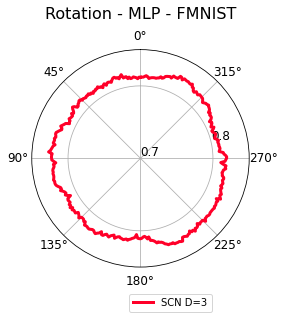

In [22]:
# Plot acc
colors = plt.cm.gist_rainbow(np.linspace(0, 1, 5))

theta = np.arange(0, 360, 1) / 180 * math.pi

fig = plt.figure()
fig.tight_layout()
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

file_name = f'output/{arch}_{dataset}_{nlayers}_{width}_{dimensions}/acc.npy'
acc_hhn = pickle.loads(np.load(file_name))
ax.plot(theta, acc_hhn['acc'], label=f'SCN D={dimensions}', color=colors[0], lw=3)

ax.set_theta_zero_location("N")
ax.set_rticks([0.7, 0.8, 0.90])  # Less radial ticks
ax.set_rmin(0.7)
ax.set_rmax(0.85)
ax.set_rlabel_position(-77.5)  # Move radial labels away from plotted line
ax.grid(True)
plt.title('Rotation - MLP - FMNIST', fontsize=16, pad=20)
plt.legend(bbox_to_anchor=(0.85, -0.1), ncol=2, prop={'size': 10})
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
# plt.savefig(f"viz_acc_{arch}_{dataset}_{nlayers}_{width}.png", bbox_inches='tight', dpi=100)
plt.show()

<Figure size 432x288 with 0 Axes>

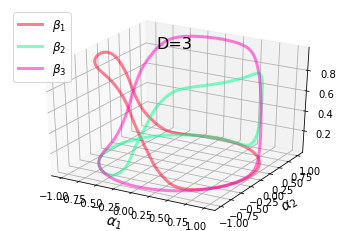

In [23]:
# Beta space
plt.rcParams.update({'font.size': 10, 'legend.fontsize': 14})

fig = plt.figure()
fig.tight_layout()
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"})
            
file_name = f'output/{arch}_{dataset}_{nlayers}_{width}_{dimensions}/acc.npy'
acc_hhn = pickle.loads(np.load(file_name))
plt.rc('font', **{'size': 4})
cols = cm.gist_rainbow(np.linspace(0, 1, dimensions))
xline = np.sin(theta)
yline = np.cos(theta)
for i in range(len(acc_hhn['beta_space'][0])):
    zline = acc_hhn['beta_space'][:, i]
    ax.plot(xline, yline, zline, alpha=0.5, color=cols[i], label=r'$\beta_{%d}$' % (i + 1), lw=3)
    ax.legend(loc='upper left', prop={'size': 12})
    ax.axes.xaxis.labelpad = 5
    ax.axes.yaxis.labelpad = 5
    ax.set_xlabel(r'$\alpha_1$', fontsize=14)
    ax.set_ylabel(r'$\alpha_2$', fontsize=14)
    ax.grid(True, linestyle=':')
    ax.set_title(f'D={dimensions}', fontsize=16)
# plt.savefig(f"viz_beta_{arch}_{dataset}_{nlayers}_{width}.png", bbox_inches='tight', dpi=100)
plt.show()